# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [134]:
! pip install Pillow

In [135]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [136]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [137]:
!ls MNIST

processed  raw


In [138]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [139]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

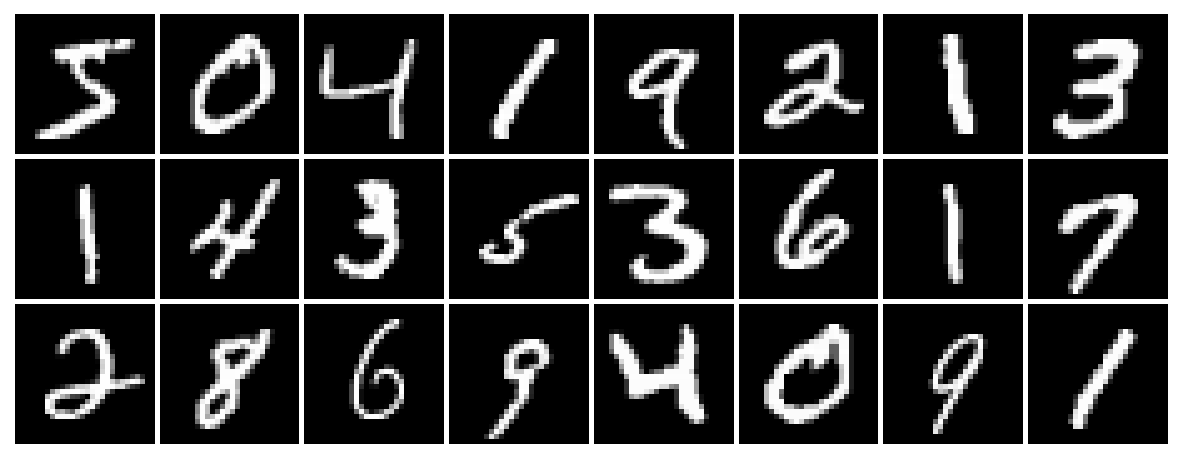

In [140]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


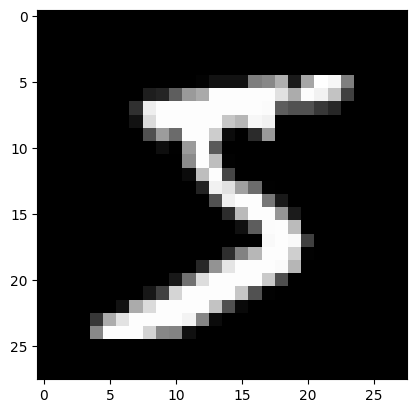

In [141]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [142]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [143]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.1780,  0.2305, -0.3017,  0.0991,  0.0263, -0.0241,  0.0431, -0.0298,
         -0.2844,  0.0418],
        [ 0.0390,  0.3284, -0.2970, -0.1063, -0.0789, -0.1972,  0.0568, -0.2308,
         -0.1668,  0.0649],
        [-0.0736,  0.0161,  0.0645,  0.2676,  0.0201,  0.0242, -0.0778,  0.0675,
         -0.0553,  0.1170],
        [-0.0232,  0.2070, -0.0328, -0.0427, -0.0379,  0.1282, -0.1810, -0.2664,
          0.0065,  0.2338],
        [ 0.1764,  0.2120,  0.0213, -0.2725,  0.1149, -0.1002, -0.2851, -0.2374,
         -0.2162,  0.1456]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [144]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [145]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-ojt3gsrd
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-ojt3gsrd
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


In [146]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.2628, grad_fn=<NllLossBackward0>)

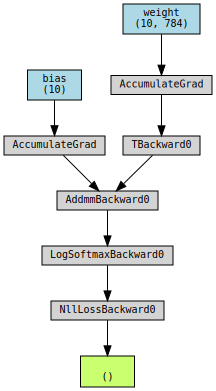

In [147]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [148]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [149]:
print('Final loss:', loss.item())

Final loss: 0.2652856111526489


### Visualizando gráfico de perda durante o treinamento

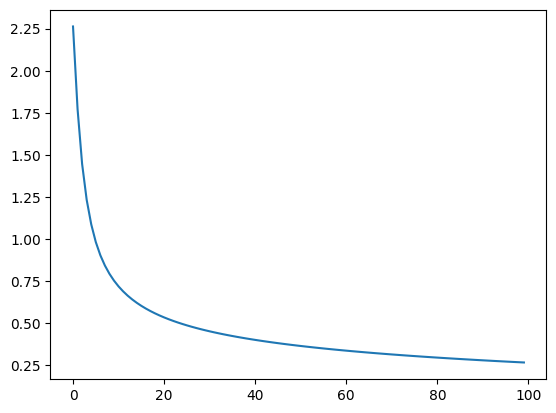

In [150]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [151]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.942


### Matriz de confusão com dados de treinamento e teste

In [152]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,91,1,0,1,1,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,1,0,2,0,3
5,0,2,0,1,0,83,0,0,1,1
6,1,0,1,1,2,2,90,0,1,0
7,0,1,1,1,0,0,0,110,0,4
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


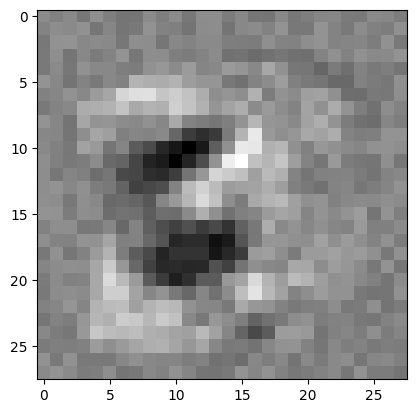

In [153]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

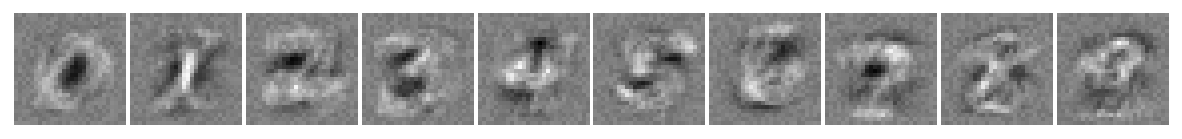

In [154]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [155]:
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f"Época [{i+1}/{epochs}] - Perda: {loss.item():.4f} - Acurácia: {accuracy:.4f}")


Época [1/100] - Perda: 0.2640 - Acurácia: 0.9420
Época [2/100] - Perda: 0.2626 - Acurácia: 0.9420
Época [3/100] - Perda: 0.2613 - Acurácia: 0.9420
Época [4/100] - Perda: 0.2600 - Acurácia: 0.9420
Época [5/100] - Perda: 0.2588 - Acurácia: 0.9420
Época [6/100] - Perda: 0.2575 - Acurácia: 0.9430
Época [7/100] - Perda: 0.2563 - Acurácia: 0.9430
Época [8/100] - Perda: 0.2550 - Acurácia: 0.9430
Época [9/100] - Perda: 0.2538 - Acurácia: 0.9430
Época [10/100] - Perda: 0.2526 - Acurácia: 0.9440
Época [11/100] - Perda: 0.2514 - Acurácia: 0.9440
Época [12/100] - Perda: 0.2502 - Acurácia: 0.9440
Época [13/100] - Perda: 0.2491 - Acurácia: 0.9450
Época [14/100] - Perda: 0.2479 - Acurácia: 0.9450
Época [15/100] - Perda: 0.2468 - Acurácia: 0.9450
Época [16/100] - Perda: 0.2457 - Acurácia: 0.9460
Época [17/100] - Perda: 0.2445 - Acurácia: 0.9460
Época [18/100] - Perda: 0.2434 - Acurácia: 0.9460
Época [19/100] - Perda: 0.2423 - Acurácia: 0.9460
Época [20/100] - Perda: 0.2413 - Acurácia: 0.9460
Época [21

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Época [1/100], Loss: 0.045237, Acc: 1.000000


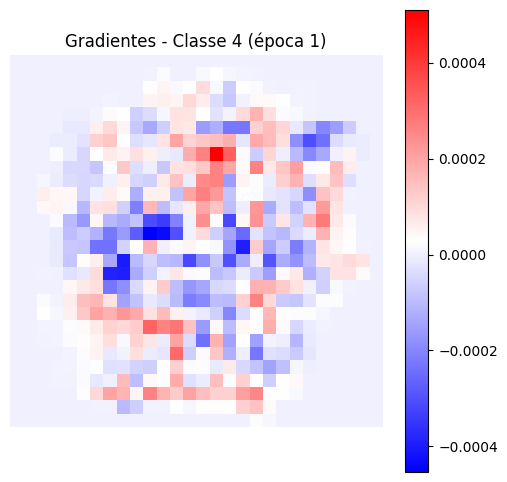

Época [10/100], Loss: 0.044839, Acc: 1.000000


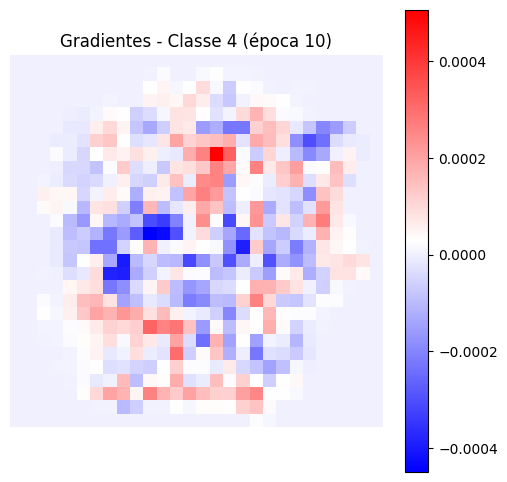

Época [20/100], Loss: 0.044405, Acc: 1.000000


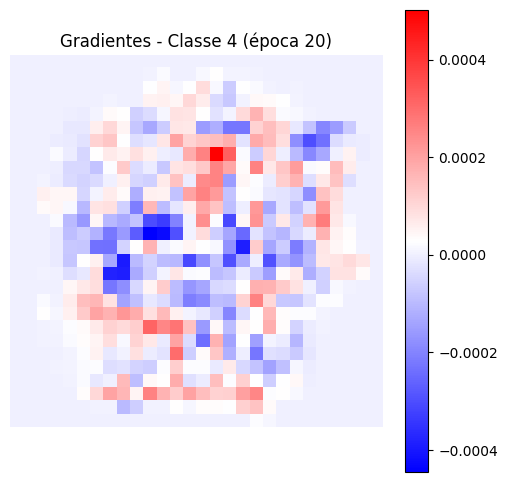

Época [30/100], Loss: 0.043979, Acc: 1.000000


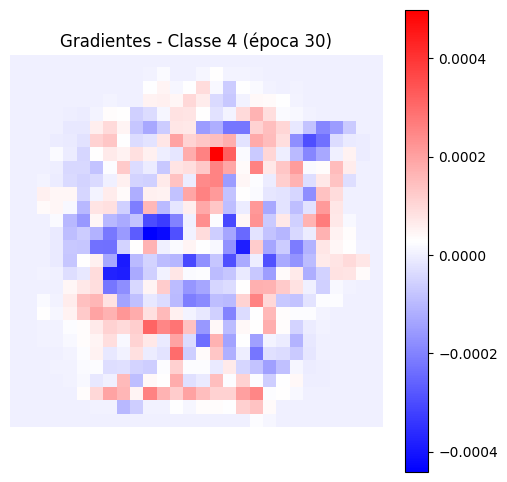

Época [40/100], Loss: 0.043560, Acc: 1.000000


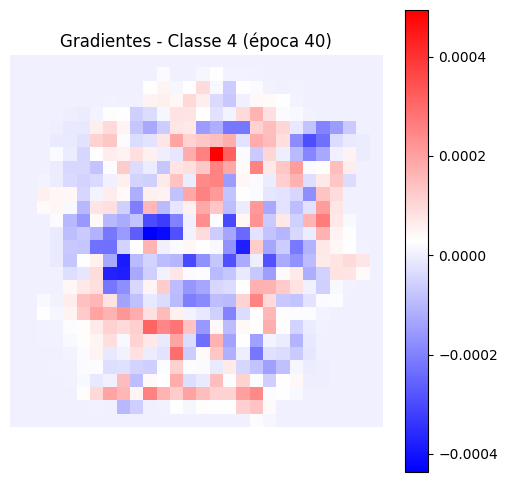

Época [50/100], Loss: 0.043150, Acc: 1.000000


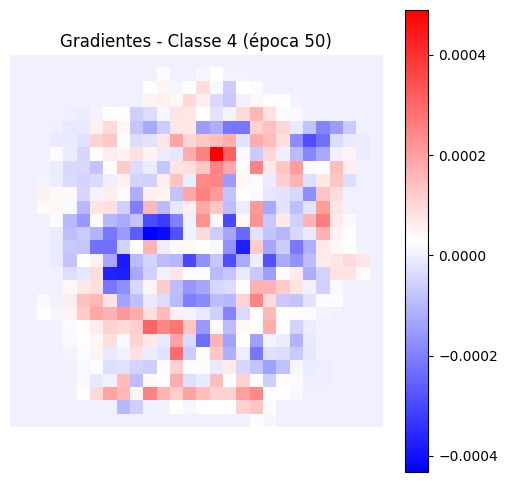

Época [60/100], Loss: 0.042747, Acc: 1.000000


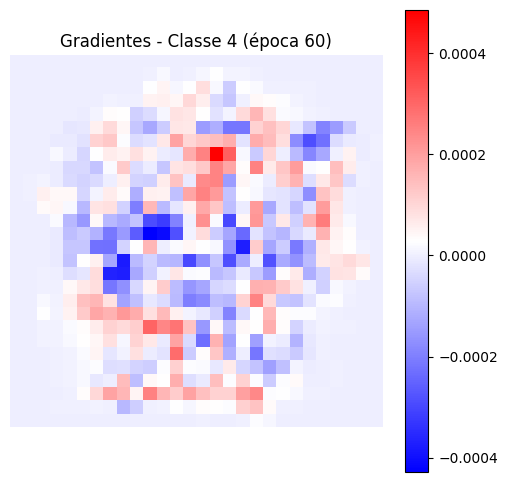

Época [70/100], Loss: 0.042351, Acc: 1.000000


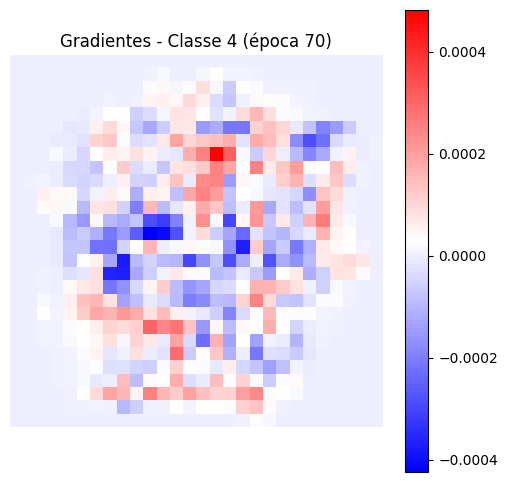

Época [80/100], Loss: 0.041962, Acc: 1.000000


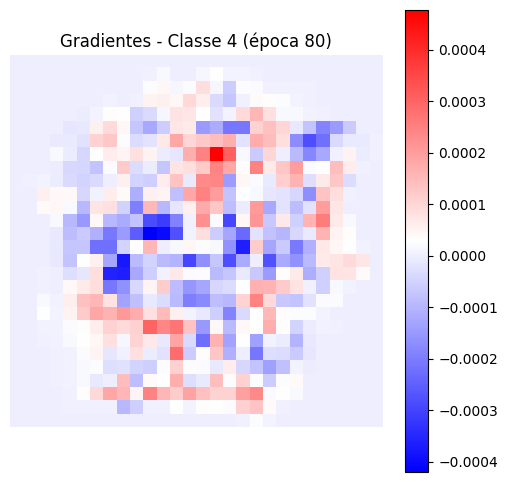

Época [90/100], Loss: 0.041580, Acc: 1.000000


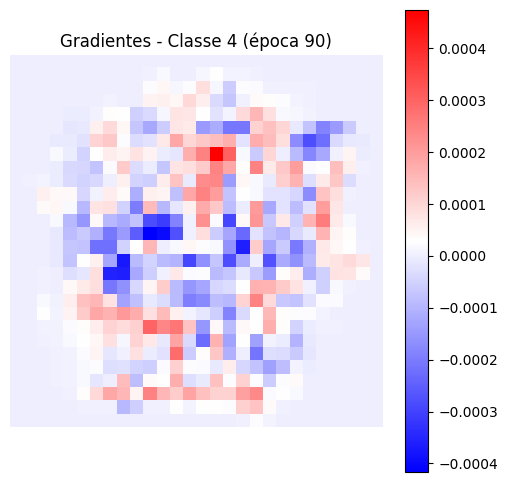

Época [100/100], Loss: 0.041205, Acc: 1.000000


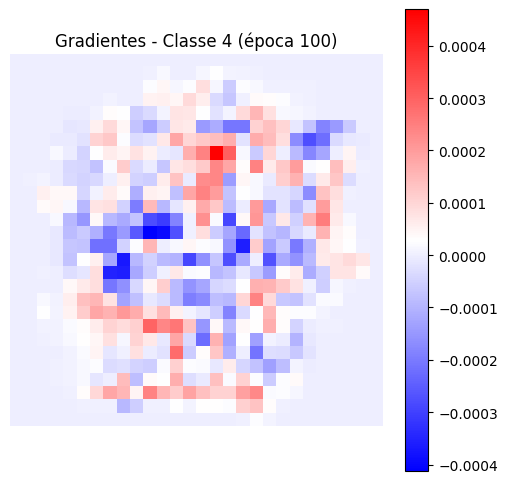

In [166]:
losses = []
zs = []
class_num = 4

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    grad_class_4 = model.weight.grad[class_num].detach().numpy()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    if (i+1) % 10 == 0 or i == 0:
        print(f"Época [{i+1}/{epochs}], Loss: {loss.item():.6f}, Acc: {accuracy:.6f}")

        # Plot dos gradientes da classe 4
        plt.figure(figsize=(6,6))
        plt.imshow(grad_class_4.reshape(28,28), cmap='bwr')
        plt.title(f"Gradientes - Classe {class_num} (época {i+1})")
        plt.colorbar()
        plt.axis('off')
        plt.show()


## Perguntas

1. Qual é o shape da matriz de entrada na rede? **(R. 28 * 28 = 784)**
2. Qual é o shape da saída da rede? **(R. 10)**
3. Qual é o número total de parâmetros da rede, incluindo o bias? **(R. 784 * 10 = 7840)** Número de entradas x o número de saídas.

# Aprendizados


Havia compreendido em sala, e também nos anteriores. Sobre a perda ir caindo e a precisão ir aumentando. Mas confesso que no plot do gradiante não consegui interpretabilidade, e seria bom um novo esclarecimento em aula.